In [1]:
# sarcasm json data binary classification
# total 26,709 headlines  

In [2]:
import json
import tensorflow as tf
import urllib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# sarcasm.json 데이터셋 파일 다운로드 , Windows용
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x29848fcfa90>)

In [7]:
# 데이터 파일 불러오기
with open('sarcasm.json','r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])    

In [10]:
# 데이터 프레임으로 보기
import pandas as pd
df = pd.DataFrame(datastore)
df = df.iloc[:,1:]

print(type(datastore[0]))  # <class 'dict'>
print(df.shape)            # (26709, 2)
print(df['is_sarcastic'].value_counts())   # 0    14985 : not sarcastic 
                                           # 1    11724 : sarcastic
df.head(10)

<class 'dict'>
(26709, 2)
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
5,advancing the world's women,0
6,the fascinating case for eating lab-grown meat,0
7,"this ceo will send your kids to school, if you...",0
8,top snake handler leaves sinking huckabee camp...,1
9,friday's morning email: inside trump's presser...,0


### 텍스트 전처리: Tokenizer

In [11]:
# 전처리를 위한 변수 설정
vocab_size = 10000    # 토큰화에 사용될 최대 어휘수
embedding_dim = 16    # Embedding 계층의 output size 
max_length = 100      # 한 문장의 길이, 데이터 셋의 길이, maxlen
trunc_type = 'post'   # maxlen보다 클때 잘라낼 유형, 'post' : 뒤쪽
padding_type = 'post' # maxlen보다 작을때 0을 추가할 유형, 'post' : 뒤쪽
oov_tok = "<OOV>"     # Out-Of-Vocabulary(단어 집합에 없는 단어)
training_size = 20000 # 학습 데이터의 갯수

In [33]:
# train(20000)/test(6709) data split 
training_sentences = sentences[:training_size]
training_labels = labels[:training_size]

testing_sentences = sentences[training_size:]
testing_labels = labels[training_size:]

In [35]:
# 토큰나이저를 시행하여 단어를 숫자값, 인덱스로 변환하여 저장

# 가장 빈도가 높은 10000개의 단어들만 사용하여 토큰화
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)

# 단어 인덱스를 구축 
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
# print(word_index)

# 문자열을 정수 인덱스의 리스트로 변환 : 정수 인코딩
training_sequences = tokenizer.texts_to_sequences(training_sentences) # type은 list
# print(training_sequences[0])

# 패딩, 벡터 표현을 얻음 : 신경망에 입력할 X값
training_padded = pad_sequences(training_sequences,maxlen=max_length,
                                padding=padding_type,truncating=trunc_type)

# print(training_padded[0])

# test 데이터 : 정수 인덱스의 리스트로 변환
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

# test 데이터 : 벡터 표현을 얻음 
testing_padded = pad_sequences(testing_sequences,maxlen=max_length,
                                padding=padding_type,truncating=trunc_type)

print(training_padded.shape)  # (20000, 100)
print(testing_padded.shape)   # (6709, 100)

(20000, 100)
(6709, 100)


In [38]:
# list를 array로 변환
import numpy as np
training_labels = np.array(training_labels)  # (20000,)
testing_labels = np.array(testing_labels)    # (6709,)

### 학습모델

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), # feature를 1 차원 벡터로 변환
    tf.keras.layers.Dense(24,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')                      
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [46]:
# 학습
history = model.fit(training_padded,training_labels,epochs=30,
                    validation_data=(testing_padded,testing_labels))

Epoch 1/30
625/625 [==============================] - 5s 4ms/step - loss: 0.6760 - accuracy: 0.5586 - val_loss: 0.6400 - val_accuracy: 0.5633
Epoch 2/30
625/625 [==============================] - 2s 4ms/step - loss: 0.5389 - accuracy: 0.7364 - val_loss: 0.4869 - val_accuracy: 0.7646
Epoch 3/30
625/625 [==============================] - 2s 4ms/step - loss: 0.4069 - accuracy: 0.8670 - val_loss: 0.4187 - val_accuracy: 0.8280
Epoch 4/30
625/625 [==============================] - 2s 3ms/step - loss: 0.3334 - accuracy: 0.8917 - val_loss: 0.3850 - val_accuracy: 0.8463
Epoch 5/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2796 - accuracy: 0.9108 - val_loss: 0.3686 - val_accuracy: 0.8515
Epoch 6/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2419 - accuracy: 0.9219 - val_loss: 0.3627 - val_accuracy: 0.8524
Epoch 7/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2113 - accuracy: 0.9327 - val_loss: 0.3867 - val_accuracy: 0.8420
Epoch 

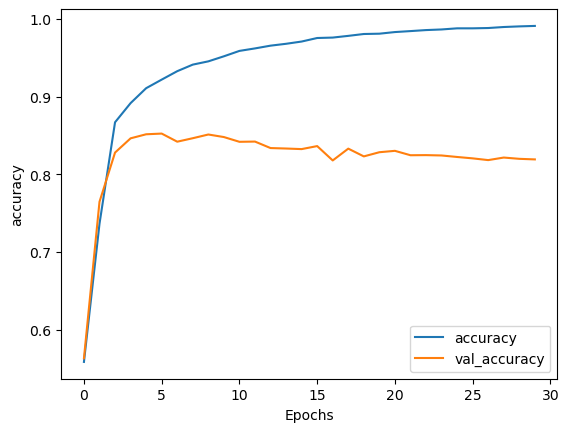

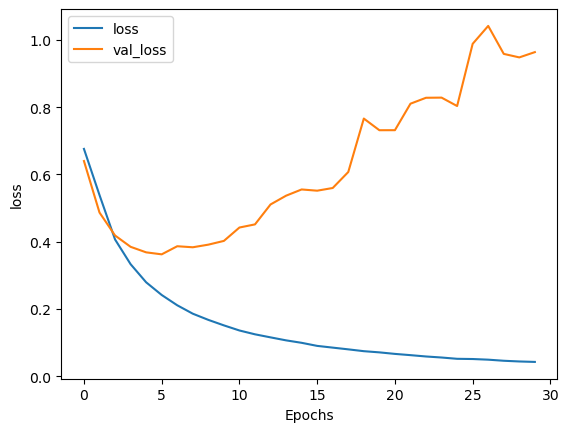

In [47]:
# 시각화
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### 모델 개선

In [51]:
# LSTM사용
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')    
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 16)           160000    
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 128)         41472     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [52]:
# 학습 :  GPU , 약 12분 소요
history = model.fit(training_padded,training_labels,epochs=30,
                    validation_data=(testing_padded,testing_labels))

Epoch 1/30
625/625 [==============================] - 33s 41ms/step - loss: 0.4265 - accuracy: 0.7907 - val_loss: 0.3458 - val_accuracy: 0.8441
Epoch 2/30
625/625 [==============================] - 24s 39ms/step - loss: 0.2412 - accuracy: 0.8998 - val_loss: 0.3355 - val_accuracy: 0.8560
Epoch 3/30
625/625 [==============================] - 24s 39ms/step - loss: 0.1714 - accuracy: 0.9317 - val_loss: 0.3814 - val_accuracy: 0.8527
Epoch 4/30
625/625 [==============================] - 25s 40ms/step - loss: 0.1261 - accuracy: 0.9526 - val_loss: 0.4241 - val_accuracy: 0.8492
Epoch 5/30
625/625 [==============================] - 25s 40ms/step - loss: 0.0933 - accuracy: 0.9659 - val_loss: 0.5080 - val_accuracy: 0.8469
Epoch 6/30
625/625 [==============================] - 29s 47ms/step - loss: 0.0727 - accuracy: 0.9742 - val_loss: 0.6061 - val_accuracy: 0.8423
Epoch 7/30
625/625 [==============================] - 27s 43ms/step - loss: 0.0592 - accuracy: 0.9789 - val_loss: 0.6289 - val_accuracy:

In [54]:
# 성능 약간 개선됨

In [53]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[2]))
print(training_sentences[2])
print(labels[2])

mom starting to fear son's web series closest thing she will have to grandchild ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

In [60]:
# 예측
sentence = ["granny starting to fear spiders in the garden might be real",
            "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,
                       truncating=trunc_type)
padded.shape  # (2,100)
preds = model.predict(padded)
print(preds)
print(np.round(preds))

1/1 [==============================] - 0s 32ms/step
[[1.0239962e-03]
 [2.3583454e-05]]
[[0.]
 [0.]]


In [63]:
# 예측
sentence = ["Head of Canada's spy agency announces he's stepping down from the job",
            "Old Video of Joe Biden Talking About Resignation Falsely Shared as Recent"]
           
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,
                       truncating=trunc_type)
print(padded.shape)  # (2,100)
preds = model.predict(padded)
print(preds)
print(np.round(preds))

(2, 100)
1/1 [==============================] - 0s 31ms/step
[[1.       ]
 [0.9999981]]
[[1.]
 [1.]]


### Keras Tokenizer 설명

In [64]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

tokenizer = Tokenizer(num_words = 100, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences, maxlen=5)
print("\nWord Index = " , word_index)
print("\nSequences = " , sequences)
print("\nPadded Sequences:")
print(padded)


# Try with words that the tokenizer wasn't fit to
test_data = [
    'i really love my dog',
    'my dog loves my manatee'
]

test_seq = tokenizer.texts_to_sequences(test_data)
print("\nTest Sequence = ", test_seq)

padded = pad_sequences(test_seq, maxlen=10)
print("\nPadded Test Sequence: ")
print(padded)


Word Index =  {'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}

Sequences =  [[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]

Padded Sequences:
[[ 0  5  3  2  4]
 [ 0  5  3  2  7]
 [ 0  6  3  2  4]
 [ 9  2  4 10 11]]

Test Sequence =  [[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]

Padded Test Sequence: 
[[0 0 0 0 0 5 1 3 2 4]
 [0 0 0 0 0 2 4 1 2 1]]
